In [3]:
import tclab
from tclab import Plotter, clock, Historian

import numpy as np
import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

Kp, τp, θp, To_p = 0.6423177737615754, 150.3121523254063, 17.396993066317368, 57.79957014481422
parameters = Kp, τp, θp

def controller_block(controller_type, parameters):
    
    if controller_type == 'P':
        Kc_P = parameters
        Gc_P = blocksim.LTI('Gc_P', 'e', 'Q', Kc_P, 1)
        return Gc_P
    
    if controller_type == 'PI':
        Kc_PI, τI_PI = parameters
        Gc_PI = blocksim.PI('Gc_PI','e','Q', Kc_PI, τI_PI)
        return Gc_PI
    
    if controller_type == 'PD':
        Kc_PD, τD_PD, α = parameters
        Gc_PD = blocksim.LTI('Gc_PD','e','Q', [Kc_PD * τD_PD * (α + 1), Kc_PD], [τD_PD * α, 1]) 
        # Used the α term for physical realizability - Textbook eq 7-12 pg 129
        return Gc_PD
    
    if controller_type == 'PID':
        Kc_PID, τI_PID, τD_PID = parameters
        Gc_PID = blocksim.PID('Gc_PID', 'e', 'Q', Kc_PID, τI_PID, τD_PID)
        return Gc_PID

def IAE_setpoints(controller_type, parameters):
    Kp, τ, θ = parameters
#setpoints
    if controller_type == 'PI':   
        # PI
        Kc = (0.758/Kp)*(θ/τ)**-0.861
        τI = τ/(1.02 - 0.323*(θ/τ))
        return Kc, τI


    if controller_type == 'PID':
        # PID
        Kc = (1.086/Kp)*(θ/τ)**-0.869
        τI = τ/(0.740 - 0.130*(θ/τ))
        τd = 0.348*τ*(θ/τ)**0.914
        return Kc, τI, τd
    
def IAE_disturbances(controller_type, parameters):
    Kp, τ , θ = parameters
#disturbance
    if controller_type == 'P':
        # P
        Kc = (0.902/Kp)*(θ/τ)**-0.985
        return Kc
    
    if controller_type == 'PI':
        # PI
        Kc = (0.984/Kp)*(θ/τ)**-0.986
        τI = (τ/0.608)*(θ/τ)**0.707
        return Kc, τI

    if controller_type == 'PID':
        # PID
        Kc = (1.435/Kp)*(θ/τ)**-0.921
        τI = (τ/0.878)*(θ/τ)**0.749
        τd = 0.482*τ*(θ/τ)**1.137
        return Kc, τI, τd
    
#P controller

def cohen_coon(controller_type, parameters):
    Kp, τ, θ =  parameters
    
    if controller_type == 'P':
        Kc = (1.03/Kp)*(τ/θ + 0.34)
        return Kc

#PI controller
    if controller_type == 'PI':
        Kc = (0.9/Kp)*(τ/θ + 0.092)
        τI = (3.33*θ)*((τ + 0.092*θ)/(τ + 2.22*θ))
        return Kc, τI


#PD controller
    if controller_type == 'PD':
        Kc = (1.24/Kp)*(τ/θ + 0.129)
        τd = 0.27*θ*((τ - 0.324*θ)/(τ + 0.129*θ))
        α = 2
        return Kc, τd, α

#PID controller
    if controller_type == 'PID':
        Kc = (1.35/Kp)*(τ/θ + 0.185)
        τI = 2.5*θ*((τ + 0.185*θ)/(τ + 0.611*θ))
        τd = 0.37*θ*(τ/(τ + 0.185*θ))
        return Kc, τI, τd
    
def system_block(Kp, τp, θp):
    Gp = blocksim.LTI('Gp', 'Q', 'Tp', Kp, [τp, 1], θp) # Block of the system FOPDT model
    return Gp

parameters = Kp, τp, θp

Gc_P = controller_block('P', cohen_coon('P', parameters)) # parameters = Kc_P

Gc_PI = controller_block('PI', cohen_coon('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PD = controller_block('PD', cohen_coon('PD', parameters)) # parameters = Kc_PD, τD_PD, α

Gc_PID = controller_block('PID', cohen_coon('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

def PID_ParamD(K,τ,θ):
    A1=1.357
    B1=-0.947
    A2=0.842
    B2=-0.738
    A3=0.381
    B3=0.995
    Kc=(A1*(θ/τ)**B1)/K
    τi=τ/(A2*(θ/τ)**B2)
    τd=A3*τ*(θ/τ)**B3
    return [Kc,τi,τd]

def PID_ParamS(K,τ,θ):
    A1=0.965
    B1=-0.855
    A2=0.796
    B2=-0.147
    A3=0.308
    B3=0.9292
    Kc=(A1*(θ/τ)**B1)/K
    τi=τ/(A2+(θ/τ)*B2)
    τd=A3*τ*(θ/τ)**B3
    return [Kc,τi,τd]

## **Setpoint changes**

## **PI**

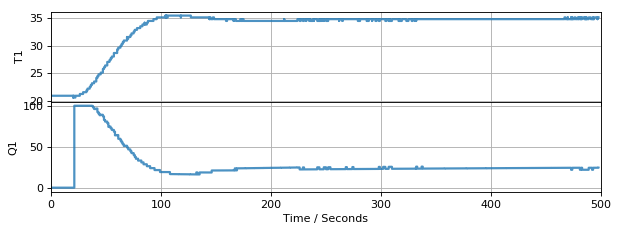

TCLab Model disconnected successfully.


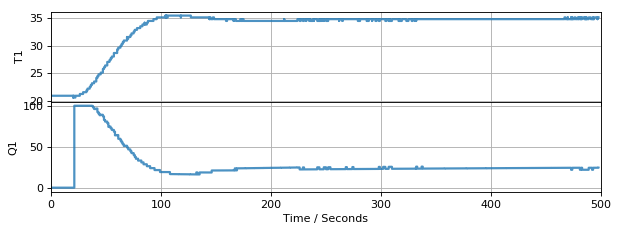

In [15]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PI_IAES.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PI_IAES.change_input(t,e)
        Gc_PI_IAES.change_state(Gc_PI_IAES.state+Gc_PI_IAES.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## **PID**

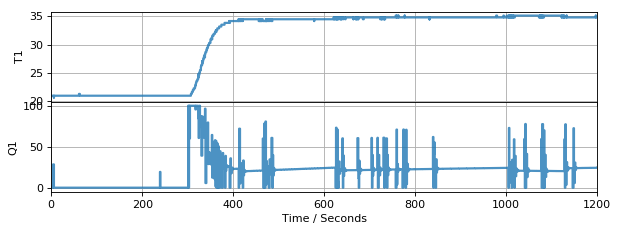

TCLab Model disconnected successfully.


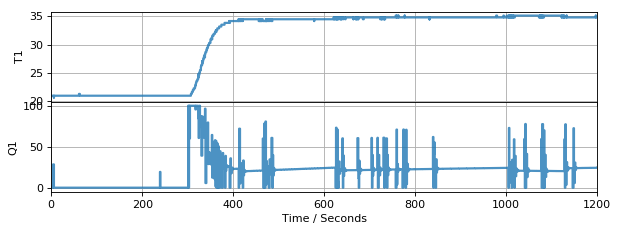

In [4]:
TCLab = tclab.setup(connected=False, speedup=10)

Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1200)
    
    for t in clock(1200):
        if t < 300:
            T1sp = 20
        else:
            T1sp = 35
            
        Q1 = lab.Q1(Gc_PID_IAES.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID_IAES.change_input(t, e)
        Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))
        
        h.update(t) 
        p.update(t)

## **Disturbances**

## **PI**

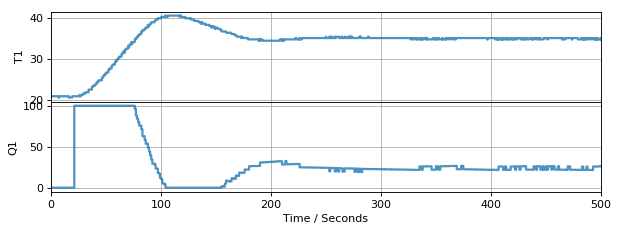

TCLab Model disconnected successfully.


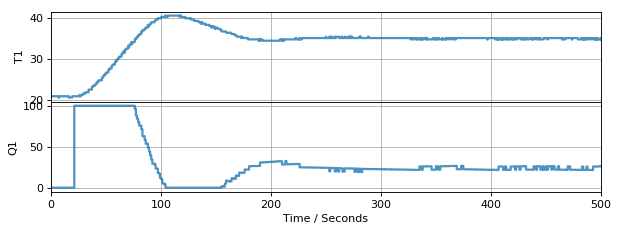

In [4]:
Gc_P_IAED = controller_block('P', IAE_disturbances('P', parameters)) # parameters = Kc_P

Gc_PI_IAED = controller_block('PI', IAE_disturbances('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PID_IAED = controller_block('PID', IAE_disturbances('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PI_IAED.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PI_IAED.change_input(t,e)
        Gc_PI_IAED.change_state(Gc_PI_IAED.state+Gc_PI_IAED.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## **PID**

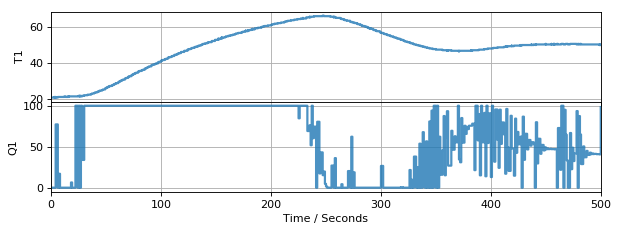

TCLab Model disconnected successfully.


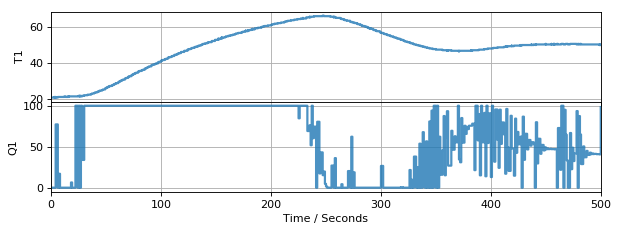

In [3]:
Gc_P_IAED = controller_block('P', IAE_disturbances('P', parameters)) # parameters = Kc_P

Gc_PI_IAED = controller_block('PI', IAE_disturbances('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PID_IAED = controller_block('PID', IAE_disturbances('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 50
            
        Q1 = lab.Q1(Gc_PID_IAED.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID_IAED.change_input(t, e)
        Gc_PID_IAED.change_state(Gc_PID_IAED.state + Gc_PID_IAED.derivative(e))
        
        h.update(t) 
        p.update(t)

# **Sampling rate**

## **PI**

## Normal 1sample/sec

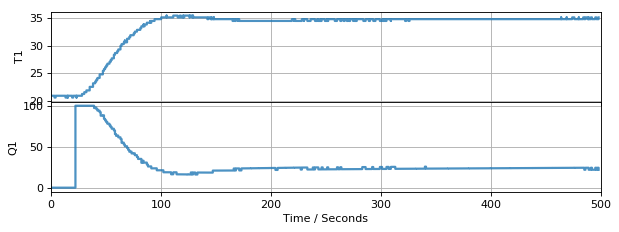

TCLab Model disconnected successfully.


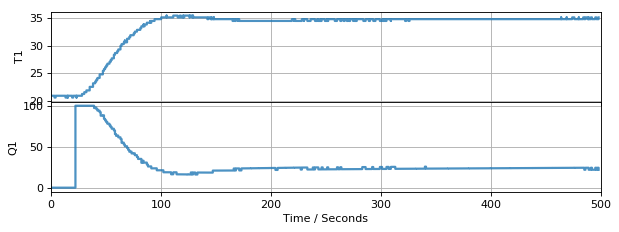

In [2]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PI_IAES.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PI_IAES.change_input(t,e)
        Gc_PI_IAES.change_state(Gc_PI_IAES.state+Gc_PI_IAES.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## 10 samples/sec

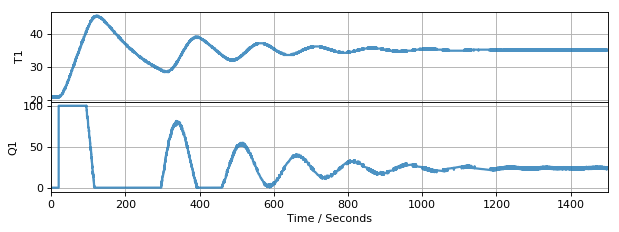

TCLab Model disconnected successfully.


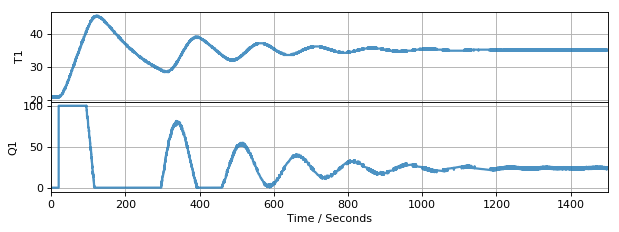

In [3]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1500)
    
    for k in clock(1500):
        for i in range(10):
            t = k+(i+1)/10
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PI_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PI_IAES.change_input(t,e)
            Gc_PI_IAES.change_state(Gc_PI_IAES.state + Gc_PI_IAES.derivative(e))


            h.update(t) 
            p.update(t)

## 5 samples/sec

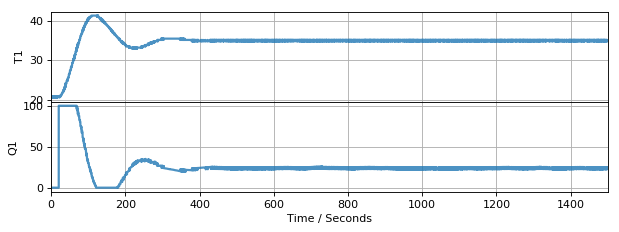

TCLab Model disconnected successfully.


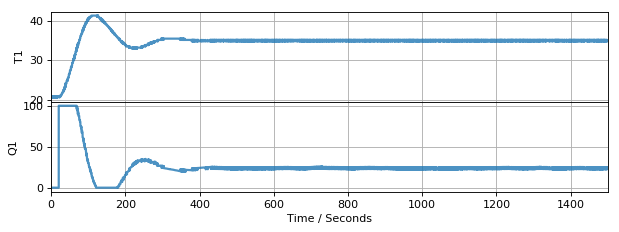

In [2]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1500)
    
    for k in clock(1500):
        for i in range(5):
            t = k+(i+1)/5
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PI_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PI_IAES.change_input(t,e)
            Gc_PI_IAES.change_state(Gc_PI_IAES.state + Gc_PI_IAES.derivative(e))


            h.update(t) 
            p.update(t)

## 2 samples/sec

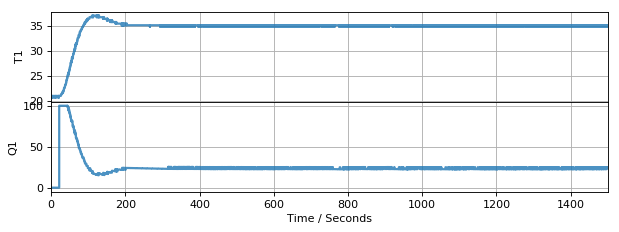

TCLab Model disconnected successfully.


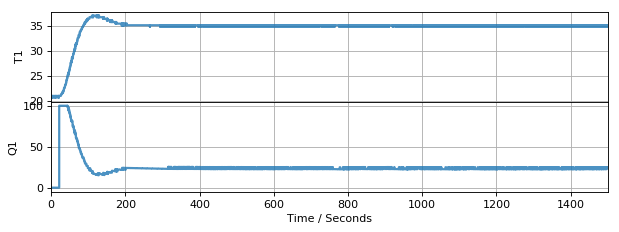

In [2]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 1500)
    
    for k in clock(1500):
        for i in range(2):
            t = k+(i+1)/2
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PI_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PI_IAES.change_input(t,e)
            Gc_PI_IAES.change_state(Gc_PI_IAES.state + Gc_PI_IAES.derivative(e))


            h.update(t) 
            p.update(t)

## 1 sample every 2 seconds

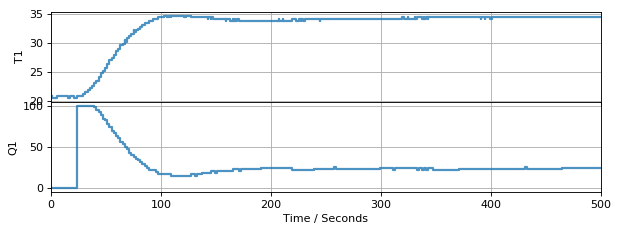

TCLab Model disconnected successfully.


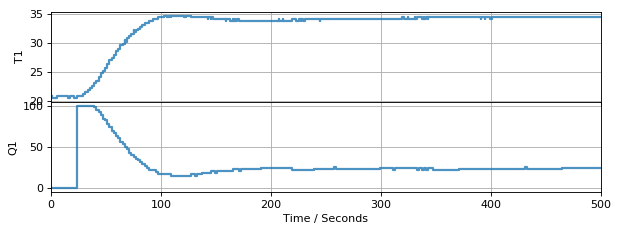

In [2]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)
from numpy import mod
with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if mod(round(t),2) > 0:
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PI_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PI_IAES.change_input(t,e)
            Gc_PI_IAES.change_state(Gc_PI_IAES.state + Gc_PI_IAES.derivative(e))

            h.update(t) 
            p.update(t)

## 1 sample every 5 seconds

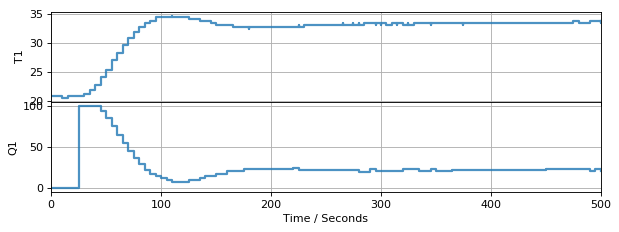

TCLab Model disconnected successfully.


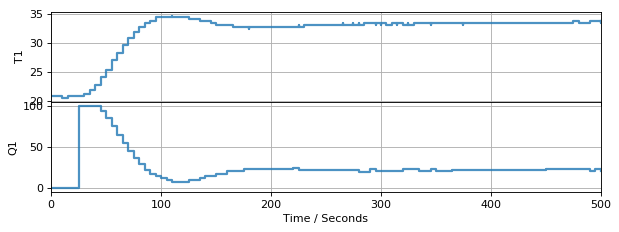

In [2]:
Gc_PI_IAES = controller_block('PI', IAE_setpoints('PI', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)
from numpy import mod
with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if mod(round(t),5) == 0:
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PI_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PI_IAES.change_input(t,e)
            Gc_PI_IAES.change_state(Gc_PI_IAES.state + Gc_PI_IAES.derivative(e))

            h.update(t) 
            p.update(t)

## **PID**

## 1sample/sec

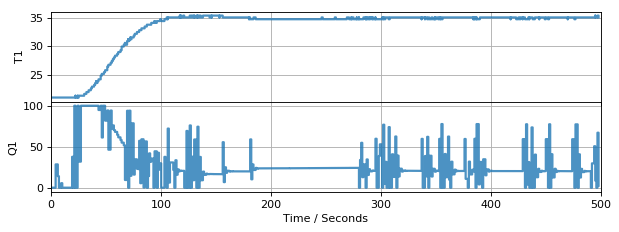

TCLab Model disconnected successfully.


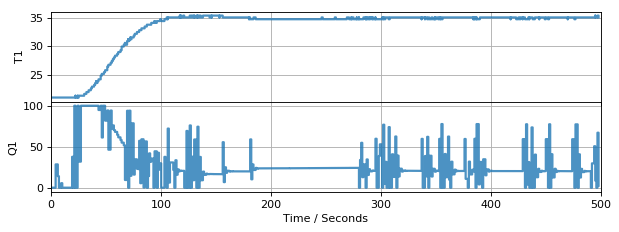

In [4]:
Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
        Q1 = lab.Q1(Gc_PID_IAES.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PID_IAES.change_input(t,e)
        Gc_PID_IAES.change_state(Gc_PID_IAES.state+Gc_PID_IAES.derivative(e))
        
        
        h.update(t) 
        p.update(t)

## 10 samples/sec

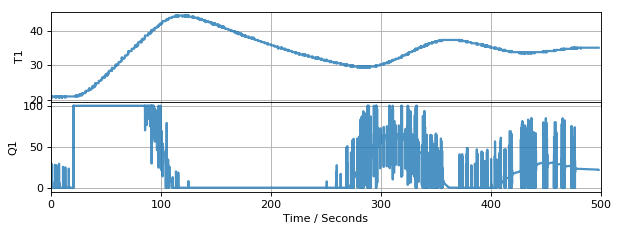

TCLab Model disconnected successfully.


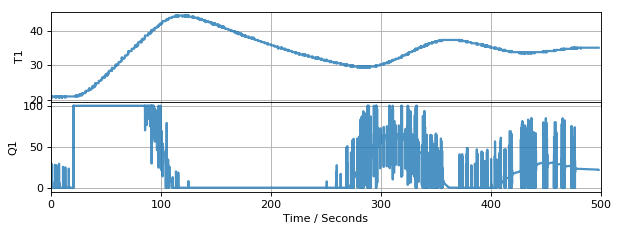

In [4]:
Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for k in clock(500):
        for i in range(10):
            t = k+(i+1)/10
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PID_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PID_IAES.change_input(t,e)
            Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))


            h.update(t) 
            p.update(t)

## 5samples/sec

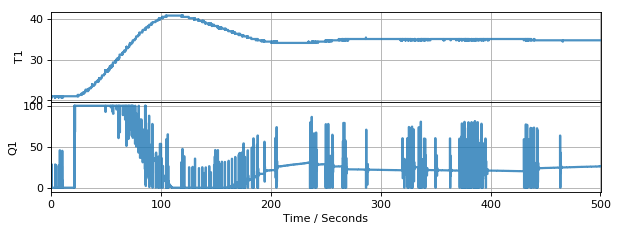

TCLab Model disconnected successfully.


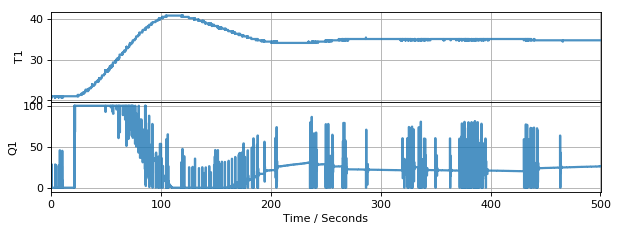

In [3]:
Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for k in clock(500):
        for i in range(5):
            t = k+(i+1)/5
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PID_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PID_IAES.change_input(t,e)
            Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))


            h.update(t) 
            p.update(t)

## 2 samples/sec

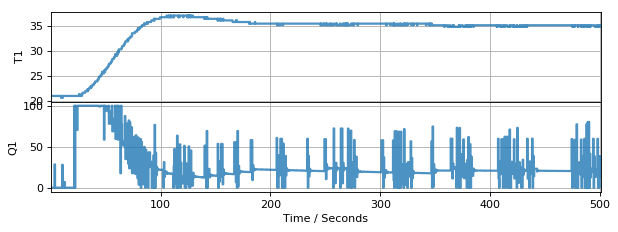

TCLab Model disconnected successfully.


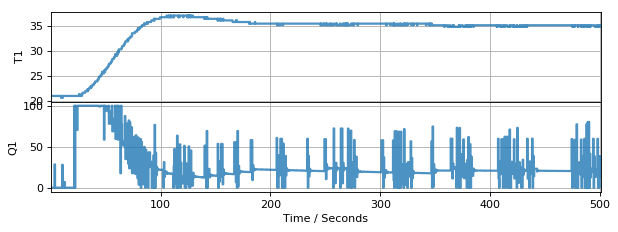

In [2]:
Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for k in clock(500):
        for i in range(2):
            t = k+(i+1)/2
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PID_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PID_IAES.change_input(t,e)
            Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))


            h.update(t) 
            p.update(t)

## 1 sample every 2 seconds

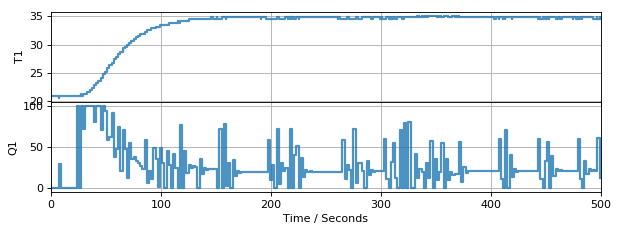

TCLab Model disconnected successfully.


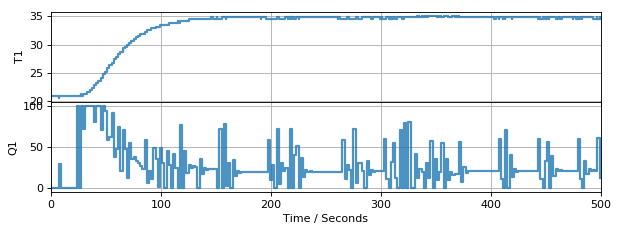

In [2]:
Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)
from numpy import mod
with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if mod(round(t),2) > 0:
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PID_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PID_IAES.change_input(t,e)
            Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))

            h.update(t) 
            p.update(t)

## 1 sample every 5 seconds

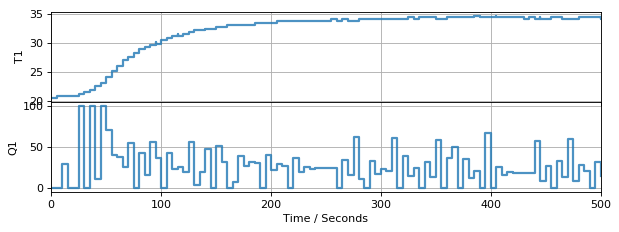

TCLab Model disconnected successfully.


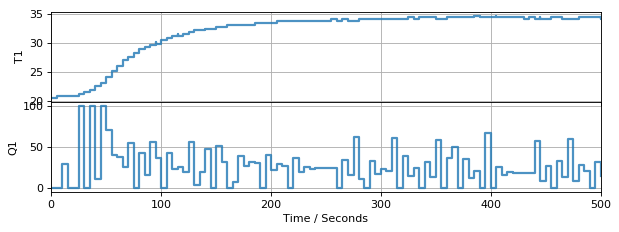

In [3]:
Gc_PID_IAES = controller_block('PID', IAE_setpoints('PID', parameters)) # parameters = Kc_PI, τI_PI

TCLab = tclab.setup(connected=False, speedup=10)
from numpy import mod
with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if mod(round(t),5) == 0:
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PID_IAES.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PID_IAES.change_input(t,e)
            Gc_PID_IAES.change_state(Gc_PID_IAES.state + Gc_PID_IAES.derivative(e))

            h.update(t) 
            p.update(t)

# **Cohen Coon**

## PI

## Step response

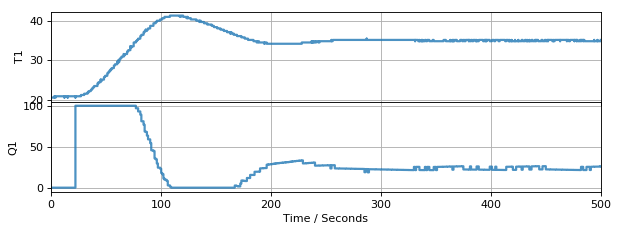

TCLab Model disconnected successfully.


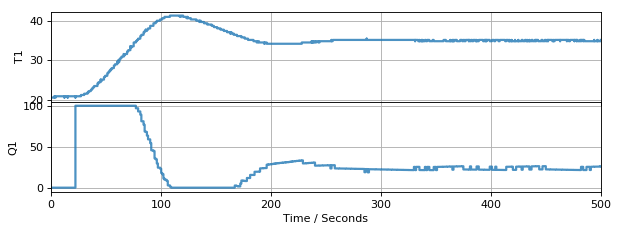

In [2]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
            
        Q1 = lab.Q1(Gc_PI.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PI.change_input(t, e)
        Gc_PI.change_state(Gc_PI.state + Gc_PI.derivative(e))
        
        h.update(t) 
        p.update(t)

## 2 samples/sec

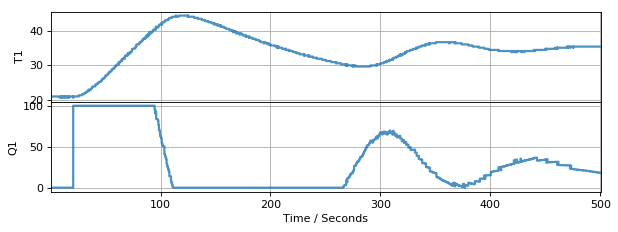

TCLab Model disconnected successfully.


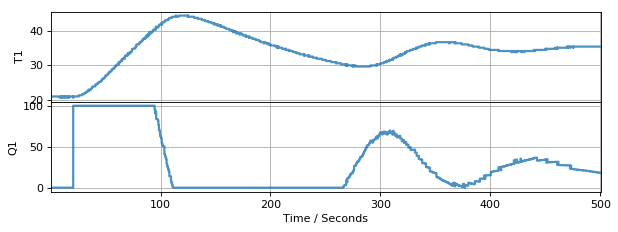

In [2]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for k in clock(500):
        for i in range(2):
            t = k+(i+1)/2
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PI.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PI.change_input(t,e)
            Gc_PI.change_state(Gc_PI.state + Gc_PI.derivative(e))


            h.update(t) 
            p.update(t)

## PID

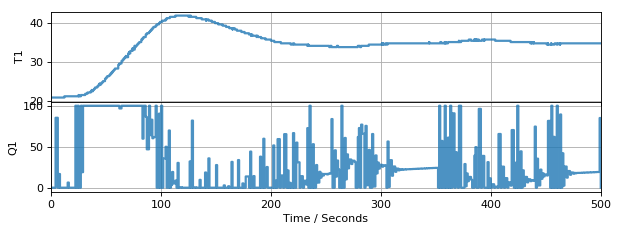

TCLab Model disconnected successfully.


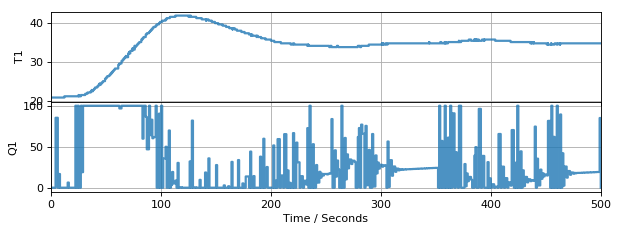

In [3]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
            
        Q1 = lab.Q1(Gc_PID.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID.change_input(t, e)
        Gc_PID.change_state(Gc_PID.state + Gc_PID.derivative(e))
        
        h.update(t) 
        p.update(t)

## PID 1 sample every 2 seconds

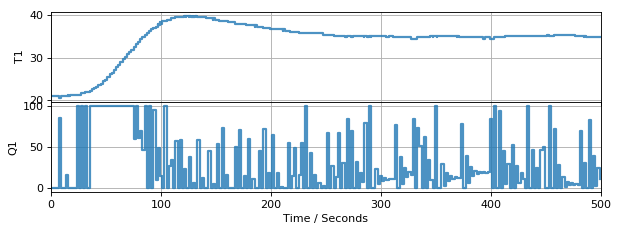

TCLab Model disconnected successfully.


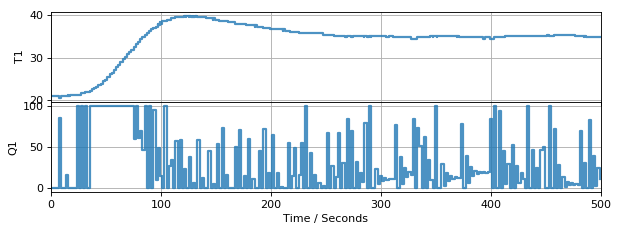

In [2]:
TCLab = tclab.setup(connected=False, speedup=10)
from numpy import mod
with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if mod(round(t),2) > 0:
            if t < 20:
                T1sp = 20
            else:
                T1sp = 35
            Q1 = lab.Q1(Gc_PID.output)
            T1 = lab.T1
            e = T1sp-T1
            Gc_PID.change_input(t,e)
            Gc_PID.change_state(Gc_PID.state + Gc_PID.derivative(e))

            h.update(t) 
            p.update(t)

## **Group 11**

## Step response

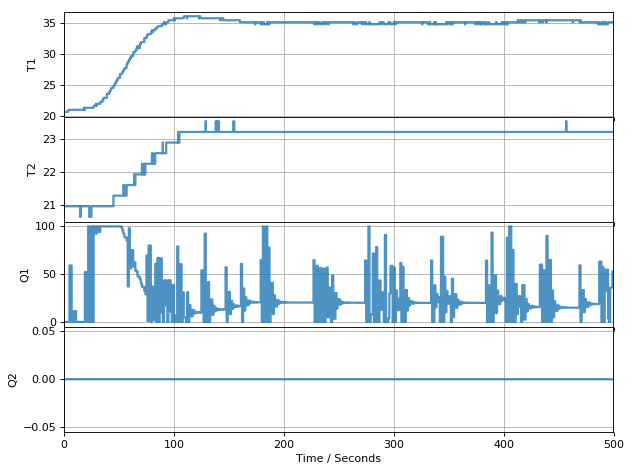

TCLab Model disconnected successfully.


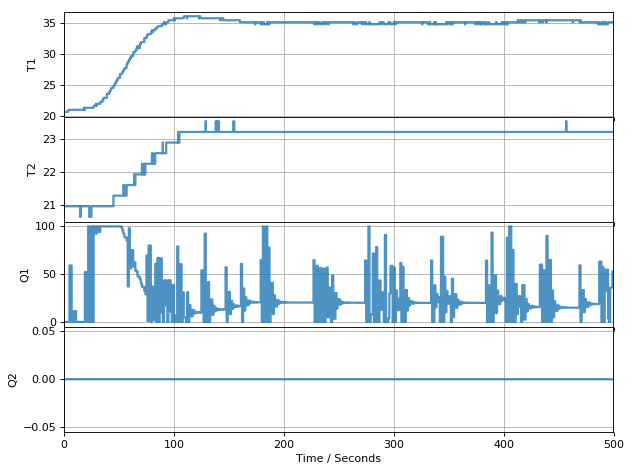

In [2]:
Kp = 0.5019805635213285 # using fit_curve
θ = 17.8503031344003
τp = 155.64345446376495
α = 0.2

Gp = blocksim.LTI("Gp", 'Q', 'T',Kp,[τp,1],7)
Gc_PIDS = blocksim.PID("Gc_PIDS","e","Q",PID_ParamS(Kp,τp,θp)[0],PID_ParamS(Kp,τp,θp)[1],PID_ParamS(Kp,τp,θp)[2])

TCLab = tclab.setup(connected=False, speedup=10)


with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    p=Plotter(h,500)
    
    for t in clock(500):
        if t<20:
            T1sp = 20
        else:
            T1sp = 35
            
        
        Q1 = lab.Q1(Gc_PIDS.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PIDS.change_input(t,e)
        Gc_PIDS.change_state(Gc_PIDS.state+Gc_PIDS.derivative(e))
            
        
        
        h.update(t) 
        p.update(t)

## Disturbance response

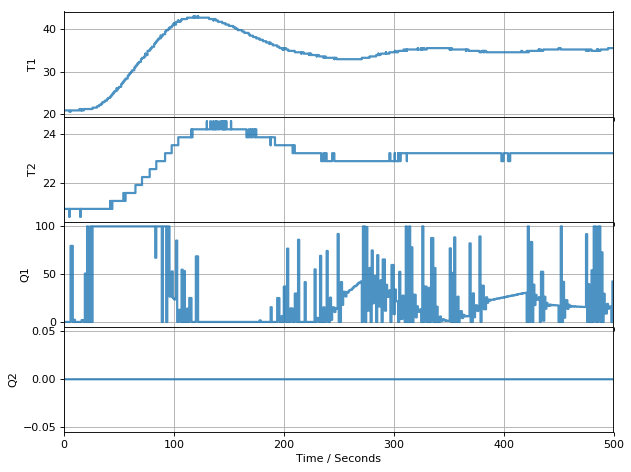

TCLab Model disconnected successfully.


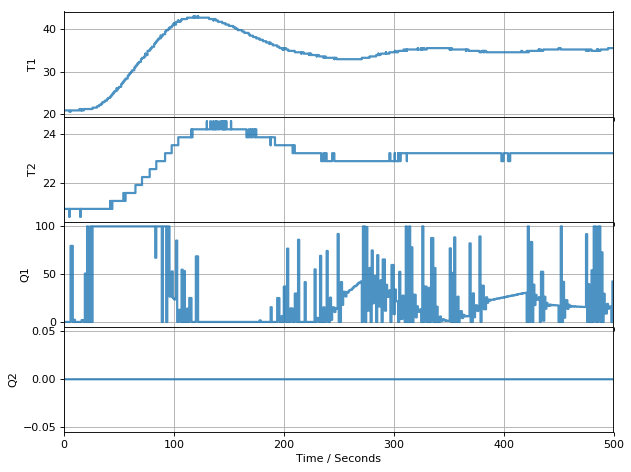

In [2]:
Kp = 0.5019805635213285 # using fit_curve
θ = 17.8503031344003
τp = 155.64345446376495
α = 0.2

Gp = blocksim.LTI("Gp", 'Q', 'T',Kp,[τp,1],7)
Gc_PIDD = blocksim.PID("Gc_PIDD","e","Q",PID_ParamD(Kp,τp,θp)[0],PID_ParamD(Kp,τp,θp)[1],PID_ParamD(Kp,τp,θp)[2])

TCLab = tclab.setup(connected=False, speedup=10)


with TCLab() as lab:
    h = tclab.Historian(lab.sources)
    p=Plotter(h,500)
    
    for t in clock(500):
        if t<20:
            T1sp = 20
        else:
            T1sp = 35
            
        
        Q1 = lab.Q1(Gc_PIDD.output)
        T1 = lab.T1
        e = T1sp-T1
        Gc_PIDD.change_input(t,e)
        Gc_PIDD.change_state(Gc_PIDD.state+Gc_PIDD.derivative(e))
            
        
        
        h.update(t) 
        p.update(t)

## **IAE**

## Setpoint response 

Use original setpoint

## Disturbance response

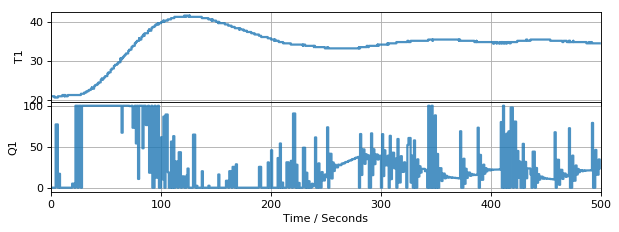

TCLab Model disconnected successfully.


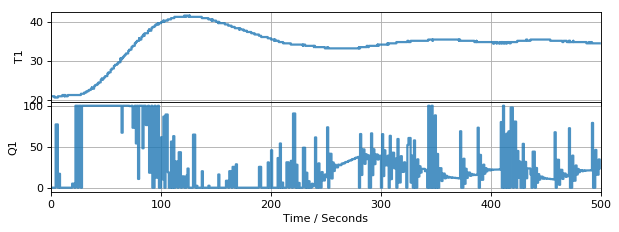

In [3]:
Gc_P_IAED = controller_block('P', IAE_disturbances('P', parameters)) # parameters = Kc_P

Gc_PI_IAED = controller_block('PI', IAE_disturbances('PI', parameters)) # parameters = Kc_PI, τI_PI

Gc_PID_IAED = controller_block('PID', IAE_disturbances('PID', parameters)) # parameters = Kc_PID, τI_PID, τD_PID

TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
               ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = Plotter(h, 500)
    
    for t in clock(500):
        if t < 20:
            T1sp = 20
        else:
            T1sp = 35
            
        Q1 = lab.Q1(Gc_PID_IAED.output)
        T1 = lab.T1
        e = T1sp - T1
        Gc_PID_IAED.change_input(t, e)
        Gc_PID_IAED.change_state(Gc_PID_IAED.state + Gc_PID_IAED.derivative(e))
        
        h.update(t) 
        p.update(t)